In [1]:
import cv2
import matplotlib.pyplot as plt
from model import FinetunedSAM
from pipeline import SlidingWindowPipeline
import torch
import numpy as np
from stardist.matching import matching_dataset
from tqdm import tqdm

/home/nathan/miniconda3/envs/SAMed/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the model
model = FinetunedSAM('facebook/sam-vit-base', finetune_vision=False, finetune_prompt=True, finetune_decoder=True, lora_vision=True)
trained_samcell_path = '/home/nathan/Desktop/SAMCell-t4/checkpoints/samcell-cyto-5/pytorch_model.bin'
model.load_weights(trained_samcell_path)

pipeline = SlidingWindowPipeline(model, 'cuda', crop_size=256)

test_image = cv2.imread('/home/nathan/Desktop/PBL-datasets/processed/imgs/PBL_N2A/3.png', cv2.IMREAD_GRAYSCALE)
#rescale to 1000 (largest dimension)
if test_image.shape[0] > test_image.shape[1]:
    test_image = cv2.resize(test_image, (int(test_image.shape[1] * 1000 / test_image.shape[0]), 1000))
else:
    test_image = cv2.resize(test_image, (1000, int(test_image.shape[0] * 1000 / test_image.shape[1])))

In [4]:
def convert_label_to_rainbow(label):
    label_rainbow = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    for cell in np.unique(label):
        if cell == 0:
            continue #background
        label_rainbow[label == cell] = np.random.rand(3) * 255

    return label_rainbow

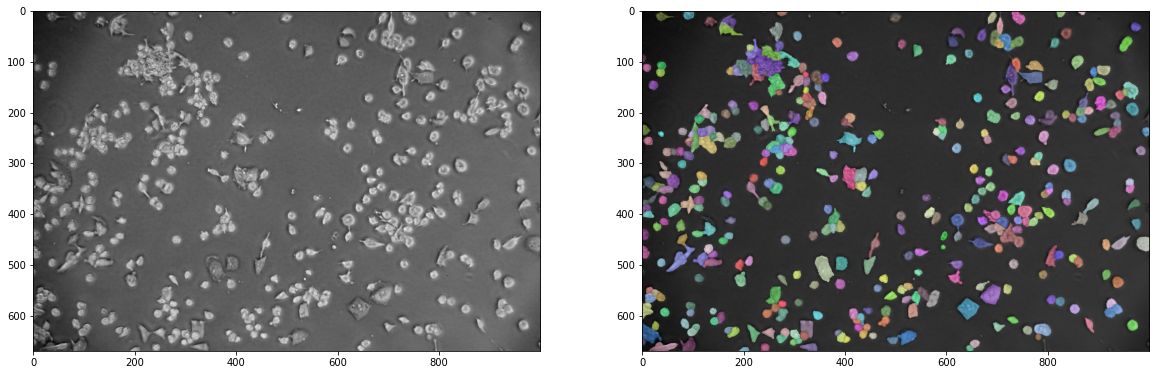

In [5]:
# Run the pipeline
output = pipeline.run(test_image)
output_rgb = convert_label_to_rainbow(output)

# Display the output
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(test_image, cmap='gray')
ax[1].imshow(output_rgb)
ax[1].imshow(test_image, cmap='gray', alpha=0.5)
plt.show()

running...


  0%|          | 0/5 [00:00<?, ?it/s]

0
(858, 1280)


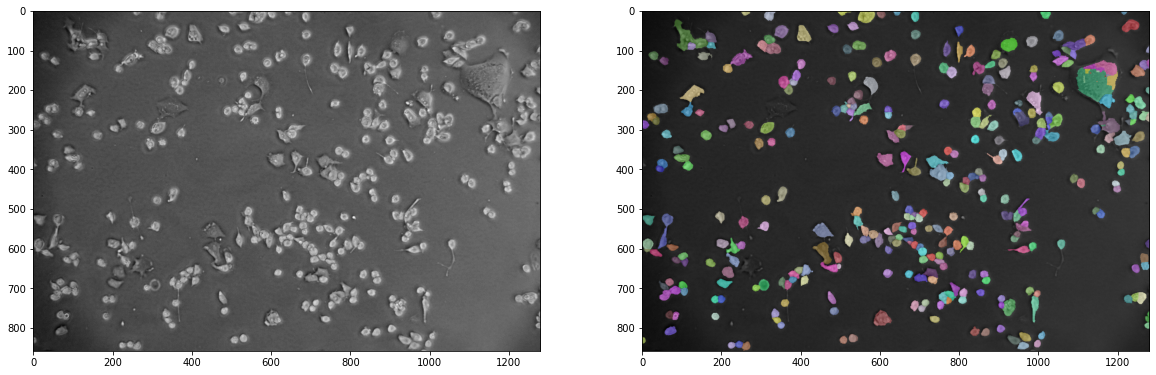

 20%|██        | 1/5 [00:03<00:14,  3.74s/it]

1
(858, 1280)


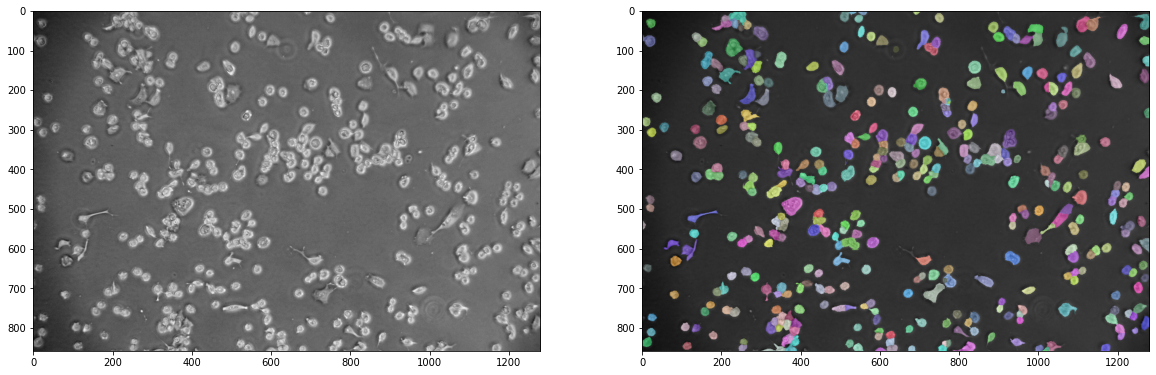

 40%|████      | 2/5 [00:07<00:11,  3.82s/it]

2
(858, 1280)


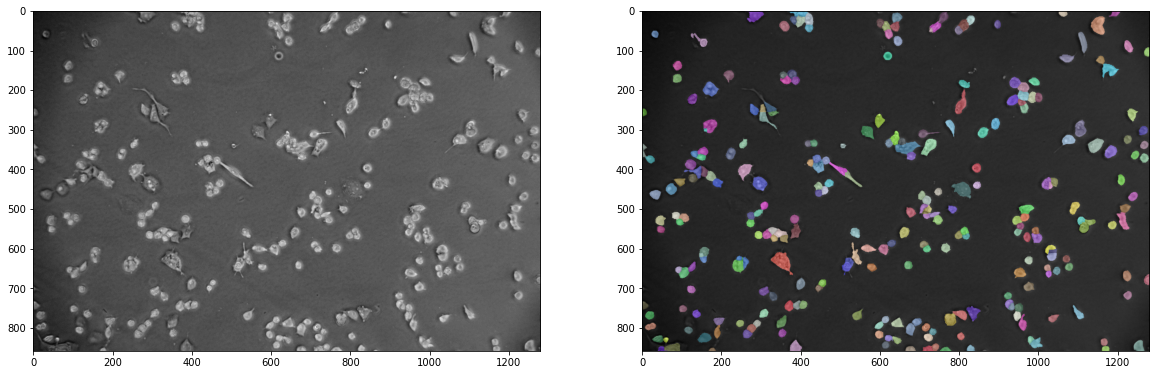

 60%|██████    | 3/5 [00:11<00:07,  3.76s/it]

3
(858, 1280)


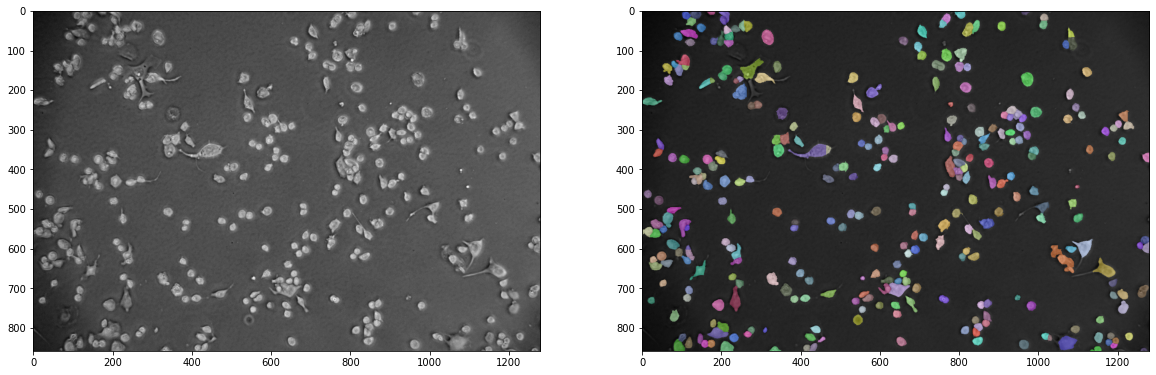

 80%|████████  | 4/5 [00:14<00:03,  3.73s/it]

4
(858, 1280)


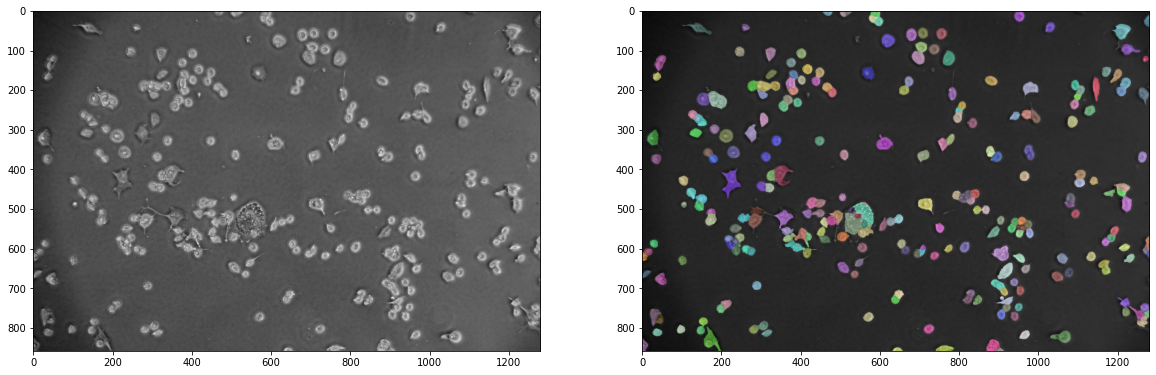

100%|██████████| 5/5 [00:18<00:00,  3.76s/it]

[0.71089047 0.68013637 0.64512466 0.56540295 0.4457593  0.32260401
 0.1731781  0.07073658 0.00784807]


In [9]:
img_path = '../datasets/PBL_N2A/imgs.npy'
ann_path = '../datasets/PBL_N2A/anns.npy'
imgs = np.load(img_path)[:, :, :, 0]
anns = np.load(ann_path)

stats = []
print('running...')
for i in tqdm(range(len(imgs))):
    print(i)
    image_orig = imgs[i]
    ann = anns[i, :, : ].astype(np.int32)
    label, dist_map = pipeline.run(image_orig, return_dist_map=True)

    output_rgb = convert_label_to_rainbow(label)
    print(label.shape)
    # Display the output
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(image_orig, cmap='gray')
    ax[1].imshow(output_rgb)
    ax[1].imshow(image_orig, cmap='gray', alpha=0.5)
    plt.show()

    taus = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]

    test_stats = [matching_dataset([ann], [label], thresh=t, show_progress=False, parallel=True) for t in taus]
    stats.append([stat._asdict()['accuracy'] for stat in test_stats])

stats = np.array(stats)
print(stats.mean(axis=0))


In [10]:
stats = stats.mean(axis=0)
#round to 4 decimal places
stats = np.round(stats, 4)
print(stats)

[0.7109 0.6801 0.6451 0.5654 0.4458 0.3226 0.1732 0.0707 0.0078]


: 